In [1]:
import read_and_cache_data as rcd
from IPython.display import display
import ashrae_constants as const
import explore_data as exp
import pandas as pd
import matplotlib.pyplot as plt

# Import the raw data

In [2]:
raw_data = rcd.get_data('ashrae-energy-prediction', cache_file='store_raw.h5')
rcd.print_nan_counts_all_dfs(raw_data)

Importing data from store_raw.h5
NaNs for building_metadata


site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

NaNs for weather_train


site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

NaNs for weather_test


site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
dtype: int64

NaNs for train


building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

NaNs for test


row_id         0
building_id    0
meter          0
timestamp      0
dtype: int64

### Check for large values

In [3]:
thresholds = [1_00_000, 1_000_000, 10_000_000]
high_meter_buildings = exp.get_buildings_with_high_meter(raw_data['train'], thresholds)

There are 10 buildings with meter readings above 0M: {1088, 993, 1159, 778, 1099, 1197, 1168, 954, 60, 1021}
There are 1 buildings with meter readings above 1M: {1099}
There are 1 buildings with meter readings above 10M: {1099}


In [4]:
high_meter_buildings

{100000: {60, 778, 954, 993, 1021, 1088, 1099, 1159, 1168, 1197},
 1000000: {1099},
 10000000: {1099}}

/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


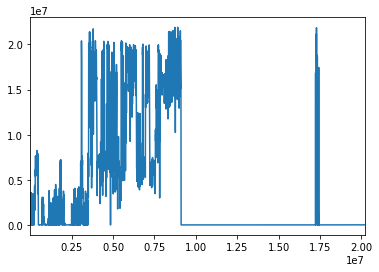

In [5]:
raw_train = raw_data['train']
for b_id in high_meter_buildings[1000000]:
    raw_data['train'][raw_train.building_id == b_id][raw_train.meter == 2].meter_reading.plot()
    plt.show()

In [6]:
#Not just one anomolous data point. Let's find out more about the building
raw_data['building_metadata'][raw_data['building_metadata'].building_id == 1099]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1099,13,1099,Education,332884,NaN,NaN


Not just one value so not sure what to do about this - leave for now

### Strange values

In [7]:
# It is reported in this discussion by @barnwellguy that All electricity meter is 0 until May 20 for site_id == 0.
buildings_site_0 = raw_data['building_metadata'].building_id[raw_data['building_metadata'].site_id == 0]
elec_buildings_site_0 = raw_train[(raw_train.building_id.isin(list(buildings_site_0)))
                                 & (raw_train.meter == 0)]
elec_buildings_site_0.loc[:,'timestamp'] = pd.to_datetime(elec_buildings_site_0['timestamp'])
elec_buildings_site_0_pre_20may = elec_buildings_site_0[elec_buildings_site_0['timestamp'] < "2016-05-21"]

/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
elec_buildings_site_0_pre_20may_pivoted = elec_buildings_site_0_pre_20may.pivot(index='timestamp',
                                     columns = 'building_id', 
                                     values = 'meter_reading')

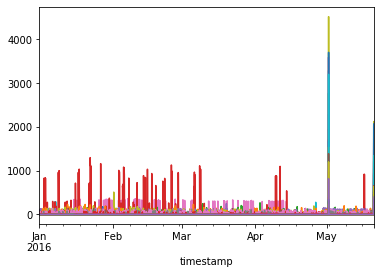

In [9]:
elec_buildings_site_0_pre_20may_pivoted.plot(legend=False)
plt.show()

There is some data there for all of the buildings but it is very odd - leave for now but bear in mind

### Are their missing timestamps?

#### Weather train

In [10]:
exp.count_missing_timestamps(raw_data['weather_train'])

There are 139773 timestamps in the data. The full date range is 8784 long and there are 16 sites so there should be 140544 timestamps in the data. There are therefore 771 missing. 


771

#### Weather test

In [11]:
exp.count_missing_timestamps(raw_data['weather_test'])

There are 277243 timestamps in the data. The full date range is 17520 long and there are 16 sites so there should be 280320 timestamps in the data. There are therefore 3077 missing. 


3077

So weather data is missing some timestamps in both test and train

### So need to...

 - fill in NAN's in weather data
 - add missing dates to weather data and interpolate the blanks
 - Not sure what to do about building 1099's steam data - doesn't seem to be just one anomoly
 - Leave the nans in the building dataframe for now - I don't think we need to use those features


## Fix them, reformat a few columns and add meter type names

In [12]:
cleaned_data = rcd.clean_data(raw_data)

Cleaning weather_train dataset
Cleaning weather_test dataset
Cleaning train dataset
Cleaning test dataset


In [13]:
exp.count_missing_timestamps(cleaned_data['weather_train'])

There are 140544 timestamps in the data. The full date range is 8784 long and there are 16 sites so there should be 140544 timestamps in the data. There are therefore 0 missing. 


0

In [14]:
exp.count_missing_timestamps(cleaned_data['weather_test'])

There are 280320 timestamps in the data. The full date range is 17520 long and there are 16 sites so there should be 280320 timestamps in the data. There are therefore 0 missing. 


0

# 1. Have a look at the data more generally
### 1.1 Building metadata

In [15]:
cleaned_data['building_metadata']

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [16]:
cleaned_data['building_metadata'].describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


## 1.2 Weather training data

In [17]:
cleaned_data['weather_train']

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,-1.0,1019.70,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,4.0,21.1,-1.0,1020.20,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.20,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.10,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.00,250.0,2.6
...,...,...,...,...,...,...,...,...,...
140539,15,2016-12-31 19:00:00,3.0,1.5,-8.0,-1.0,1007.55,180.0,5.7
140540,15,2016-12-31 20:00:00,2.8,2.0,-8.9,-1.0,1007.40,180.0,7.7
140541,15,2016-12-31 21:00:00,2.8,2.0,-7.2,-1.0,1007.50,180.0,5.1
140542,15,2016-12-31 22:00:00,2.2,2.0,-6.7,-1.0,1008.00,170.0,4.6


In [18]:
cleaned_data['weather_train'].describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,140544.000000,140544.000000,122976.000000,140544.000000,114192.000000,131760.000000,140544.000000,140544.000000
mean,7.500000,14.355675,2.633782,7.299226,2.591872,1016.142669,179.566086,3.561964
std,4.609789,10.671025,2.755691,9.823550,11.570146,7.642530,110.780692,2.333866
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.750000,7.200000,0.000000,0.600000,0.000000,1011.700000,80.000000,2.100000
50%,7.500000,15.000000,2.000000,8.200000,0.000000,1016.400000,190.000000,3.100000
75%,11.250000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


## 1.3 Consumption training data

In [19]:
cleaned_data['train']

,building_id,meter,timestamp,meter_reading,meter_type
0,0,0,2016-01-01 00:00:00,0.000,electricity
1,1,0,2016-01-01 00:00:00,0.000,electricity
2,2,0,2016-01-01 00:00:00,0.000,electricity
3,3,0,2016-01-01 00:00:00,0.000,electricity
4,4,0,2016-01-01 00:00:00,0.000,electricity
...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750,electricity
20216096,1445,0,2016-12-31 23:00:00,4.825,electricity
20216097,1446,0,2016-12-31 23:00:00,0.000,electricity
20216098,1447,0,2016-12-31 23:00:00,159.575,electricity


In [20]:
cleaned_data['test']

,row_id,building_id,meter,timestamp,meter_type
0,0,0,0,2017-01-01 00:00:00,electricity
1,1,1,0,2017-01-01 00:00:00,electricity
2,2,2,0,2017-01-01 00:00:00,electricity
3,3,3,0,2017-01-01 00:00:00,electricity
4,4,4,0,2017-01-01 00:00:00,electricity
...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,electricity
41697596,41697596,1445,0,2018-05-09 07:00:00,electricity
41697597,41697597,1446,0,2018-05-09 07:00:00,electricity
41697598,41697598,1447,0,2018-05-09 07:00:00,electricity


In [21]:
cleaned_data['train'].describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


## 2 Combined data 

### 2.1 Stick all data together, add variables for hour of day and weekend/weekday and split on meter type

In [22]:
def join_input_data_and_multi_index(meter_readings_df, building_df, weather_df):
    
    # join meter and weather data
    building_n_meter = meter_readings_df.merge(building_df, on='building_id', how='left')
    all_df = building_n_meter.merge(weather_df, on=['site_id','timestamp'], how='left')
    
    # Add time related columns
    all_df['hour'] = all_df['timestamp'].dt.hour
    all_df['weekday'] = all_df['timestamp'].dt.dayofweek
    all_df['week_number'] = all_df['timestamp'].dt.week
    all_df['month'] = all_df['timestamp'].dt.month

    all_df['is_weekend'] = all_df['weekday'].apply(lambda x: 1 if x in [0,6] else 0)
    
    
    #multi index on building id and timestamp
    all_df = all_df.set_index(['building_id', 'timestamp']).sort_index()
    
    return all_df


def split_on_meter_type(all_df):
    
    elec = all_df[all_df['meter_type'] == 'electricity']
    chilledwater = all_df[all_df['meter_type'] == 'chilledwater']
    hotwater = all_df[all_df['meter_type'] == 'hotwater']
    steam = all_df[all_df['meter_type'] == 'steam']
    
    return elec, chilledwater, hotwater, steam

In [23]:
if os.path.exists('store_split_meters.h5'):
    print('Reading from hdf')
    
    with pd.HDFStore('store_split_meters.h5') as store_split_meters:
        elec_train = store_split_meters['elec_train']
        chilledwater_train = store_split_meters['chilledwater_train']
        hotwater_train = store_split_meters['hotwater_train']
        steam_train = store_split_meters['steam_train']

#         elec_test = store_split_meters['elec_test']
#         chilledwater_test = store_split_meters['chilledwater_test']
#         hotwater_test = store_split_meters['hotwater_test']
#         steam_test = store_split_meters['steam_test']
        

    
else:
    print('Processing from cleaned dfs')
    
    print('Merging')
    train_all = join_input_data_and_multi_index(train, building, weather_train)
#    test_all = join_input_data_and_multi_index(test, building, weather_test)
    
    print('Splitting')
    elec_train, chilledwater_train, hotwater_train, steam_train = split_on_meter_type(train_all)
#    elec_test, chilledwater_test, hotwater_test, steam_test = split_on_meter_type(test_all)
    
    
    print('Writing to store')
    with pd.HDFStore('store_split_meters.h5') as store_split_meters:
        
        
        store_split_meters['elec_train'] = elec_train
        store_split_meters['chilledwater_train'] = chilledwater_train
        store_split_meters['hotwater_train'] = hotwater_train
        store_split_meters['steam_train'] = steam_train

#         store_split_meters['elec_test'] = elec_test    
#         store_split_meters['chilledwater_test'] = chilledwater_test
#         store_split_meters['hotwater_test'] = hotwater_test
#         store_split_meters['steam_test'] = steam_test
#         del test_all


NameError: name 'os' is not defined

In [ ]:
hotwater_train.isna().sum()

### 2.2 Correlate features with meter reading for each building and meter type

In [ ]:
CORRELATORS = ['air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr', 'sea_level_pressure',
               'wind_direction','wind_speed', 'hour', 'weekday', 'month', 'is_weekend']
def produce_correlation_df(train_df, y_variable='meter_reading', buildings=None,  correlators=CORRELATORS):
    if buildings==None:
        buildings = list(set(train_df.index.get_level_values('building_id')))
    correlations_df = pd.DataFrame()
    for building_id in buildings:
        df =  train_df.loc[building_id] 
        correlations = df.corr()[y_variable]
        correlations = correlations[correlators]
        correlations_df[building_id] = correlations
    correlations_df['mean'] = correlations_df.mean(axis=1)
    correlations_df['st_dev'] = correlations_df.std(axis=1)
    correlations_df = correlations_df.T
    correlations_df.sort_values(by='mean', axis=1, ascending=False)
    
    return correlations_df

def plot_correlation_distribution(correlations_df):
    for variable in correlations_df.columns:
        sns.distplot(list(correlations_df[variable].dropna()), label=variable)
    plt.legend()
    plt.show()

def plot_correlation_values(correlations_df):
    correlations_df.drop(['mean', 'st_dev'], axis=0).plot()
    plt.show()
    
def explore_correlations(buildings_correlations):
    
    plot_correlation_values(buildings_correlations)
    plot_correlation_distribution(buildings_correlations)
    plot_correlation_distribution(buildings_correlations[['air_temperature', 'dew_temperature']])

In [ ]:
# take a subset of the buildings to check 
building_subset = list(range(30))
elec_train_subset = elec_train[elec_train.index.get_level_values('building_id').isin(building_subset)]
elec_buildings_subset_correlations = produce_correlation_df(elec_train_subset, buildings=building_subset)

In [ ]:
explore_correlations(elec_buildings_subset_correlations)

In [ ]:
del building_subset, elec_train_subset, elec_buildings_subset_correlations

#### Electric meters

In [ ]:
elec_correlations = produce_correlation_df(elec_train)
explore_correlations(elec_correlations)

In [ ]:
elec_correlations

#### Chilled water meters

In [ ]:
chilledwater_correlations = produce_correlation_df(chilledwater_train)
explore_correlations(chilledwater_correlations)

In [ ]:
chilledwater_correlations

#### Hot water meters

In [ ]:
hotwater_correlations = produce_correlation_df(hotwater_train)
explore_correlations(hotwater_correlations)

In [ ]:
hotwater_correlations

#### Steam meters

In [ ]:
steam_correlations = produce_correlation_df(steam_train)
explore_correlations(steam_correlations)

In [ ]:
steam_correlations

## 2.3 Integrate data over a week and look at impact of weather variables then (to take away time dependance)

In [ ]:
WEEKLY_ATTRIBUTES = ['meter_reading','air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr',
                     'sea_level_pressure', 'wind_direction','wind_speed', 'week_number', 'month']
WEEKLY_CORRELATORS = ['air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr',
                      'sea_level_pressure', 'wind_direction','wind_speed', 'month']

In [ ]:
def produce_weekly_average_data(df, weekly_attributes=WEEKLY_ATTRIBUTES):
    df_weekly_means = df[weekly_attributes].groupby(['building_id', 'week_number']).mean()
    df_weekly_means['building_id'] = list(df_weekly_means.index.get_level_values('building_id'))
    return df_weekly_means

def produce_weekly_degree_hours(df, set_point_temp):
    df_temp = df[['meter_reading','air_temperature','week_number']].copy()
    df_temp['delta_temp'] = df_temp['air_temperature'] - set_point_temp
    df_temp = df_temp.drop(columns='air_temperature')
    df_weekly_dh = df_temp.groupby(['building_id', 'week_number']).sum()  
    df_weekly_dh['building_id'] = list(df_weekly_dh.index.get_level_values('building_id'))
    return df_weekly_dh
    

In [ ]:
set_point_C = 13

#### Electric meters

In [ ]:
elec_weekly_means_df = produce_weekly_average_data(elec_train)
elec_weekly_means_corrs = produce_correlation_df(elec_weekly_means_df, correlators=WEEKLY_CORRELATORS)

elec_weekly_dh_df = produce_weekly_degree_hours(elec_train, set_point_C )
elec_weekly_dh_corrs = produce_correlation_df(elec_weekly_dh_df , correlators=['delta_temp'])

explore_correlations(elec_weekly_means_corrs)
plot_correlation_distribution(elec_weekly_dh_corrs )

#### Chilled water meters

In [ ]:
chilledwater_weekly_means_df = produce_weekly_average_data(chilledwater_train)
chilledwater_weekly_means_corrs = produce_correlation_df(chilledwater_weekly_means_df ,
                                                         correlators=WEEKLY_CORRELATORS)

chilledwater_weekly_dh_df = produce_weekly_degree_hours(chilledwater_train, set_point_C )
chilledwater_weekly_dh_corrs = produce_correlation_df(chilledwater_weekly_dh_df, correlators=['delta_temp'])

explore_correlations(chilledwater_weekly_means_corrs)
plot_correlation_distribution(chilledwater_weekly_dh_corrs )

#### Hot water meters

In [ ]:
hotwater_weekly_means_df = produce_weekly_average_data(hotwater_train)
hotwater_weekly_means_corrs = produce_correlation_df(hotwater_weekly_means_df , correlators=WEEKLY_CORRELATORS)

hotwater_weekly_dh_df = produce_weekly_degree_hours(hotwater_train, set_point_C )
hotwater_weekly_dh_corrs = produce_correlation_df(hotwater_weekly_dh_df, correlators=['delta_temp'])

explore_correlations(hotwater_weekly_means_corrs)
plot_correlation_distribution(hotwater_weekly_dh_corrs )

#### Steam meters

In [ ]:
steam_weekly_means_df = produce_weekly_average_data(steam_train)
steam_weekly_means_corrs = produce_correlation_df(steam_weekly_means_df , correlators=WEEKLY_CORRELATORS)

steam_weekly_dh_df = produce_weekly_degree_hours(steam_train, set_point_C )
steam_weekly_dh_corrs = produce_correlation_df(steam_weekly_dh_df, correlators=['delta_temp'])

explore_correlations(steam_weekly_means_corrs)
plot_correlation_distribution(steam_weekly_dh_corrs)

## 2.4 Compare strength of different correlators

In [ ]:
def compare_distributions(df_dict, variable_name_dict, title):
    for df_name, df in df_dict.items():
        sns.distplot(list(df[variable_name_dict[df_name]].dropna()), label=df_name)
    plt.title(title)
    plt.legend()
    plt.show()


In [ ]:
variable_name_dict = {'weekly_mean_air_temp':'air_temperature',
                      'weekly_degree_hours':'delta_temp',
                      'hourly_air_temp':'air_temperature'}

compare_distributions({'weekly_mean_air_temp':elec_weekly_means_corrs, 
                      'weekly_degree_hours':elec_weekly_dh_corrs,
                      'hourly_air_temp':elec_correlations},
                      variable_name_dict,
                     'elec')

compare_distributions({'weekly_mean_air_temp':chilledwater_weekly_means_corrs,
                      'weekly_degree_hours':chilledwater_weekly_dh_corrs,
                      'hourly_air_temp':chilledwater_correlations},
                     variable_name_dict, 'chilledwater')

compare_distributions({'weekly_mean_air_temp':hotwater_weekly_means_corrs,
                      'weekly_degree_hours':hotwater_weekly_dh_corrs,
                      'hourly_air_temp':hotwater_correlations},
                     variable_name_dict, 'hotwater')

compare_distributions({'weekly_mean_air_temp':steam_weekly_means_corrs,
                      'weekly_degree_hours':steam_weekly_dh_corrs,
                      'hourly_air_temp':steam_correlations},
                     variable_name_dict,
                     'steam')

# 3. Linear regression model based on air temperature only

Assume that form of equation is meter_reading = A.T(t) + B + f(t) where B = A.T_setpoint. <br>

In [ ]:
def fit_linear_regression_to_air_temp_data(df):
    
    building_ids = list(set(df.index.get_level_values('building_id')))
    df_results = pd.DataFrame(index=building_ids, columns = ['r_sq', 'intercept', 'temp_coef', 'set_point_temp'])
    df_results.index.rename('building_id', inplace=True)
    
    for building_id in building_ids:
        building_df = df.loc[building_id]
        y=building_df['meter_reading'].to_numpy()
        x=building_df['air_temperature'].to_numpy().reshape(-1, 1)
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        x=imp_mean.fit_transform(x)
        model=LinearRegression(n_jobs=-1).fit(x,y)
        r_sq = model.score(x, y)
        df_results.loc[building_id, 'r_sq'] = r_sq
        df_results.loc[building_id, 'intercept'] = model.intercept_
        df_results.loc[building_id, 'temp_coef'] = model.coef_[0]
        df_results.loc[building_id, 'set_point_temp'] = -model.intercept_/model.coef_[0]
        
    for col in list(df_results):
        df_results[col] = pd.to_numeric(df_results[col])
        
    return df_results

In [ ]:
#alternative where you throw away weeks that have 0 average meter reading for that week - save that week number

## 3.1 Air temperature - weekly averages

Integrate out the time dependancy by looking at entire weeks

Start by just fitting a from weekly_meter_reading = A.T_mean + B

In [ ]:
building_df = steam_weekly_means_df.loc[745]
y=building_df['meter_reading'].to_numpy()
x=building_df['air_temperature'].to_numpy()
plt.xlabel('air temp')
plt.ylabel('meter reading')
plt.scatter(x,y)
plt.show()

In [ ]:
building_df = steam_weekly_means_df.loc[1442]
y=building_df['meter_reading'].to_numpy()
x=building_df['air_temperature'].to_numpy()
plt.xlabel('air temp')
plt.ylabel('meter reading')
plt.scatter(x,y)
plt.show()

### 3.1.1 Fit model

In [ ]:
df_steam_weekly_results = fit_linear_regression_to_air_temp_data(steam_weekly_means_df)
df_chilledwater_weekly_results = fit_linear_regression_to_air_temp_data(chilledwater_weekly_means_df)
df_hotwater_weekly_results = fit_linear_regression_to_air_temp_data(hotwater_weekly_means_df)
df_elec_weekly_results = fit_linear_regression_to_air_temp_data(elec_weekly_means_df) 

In [ ]:
#stick them all together for use later
df_elec_weekly_results['meter'] = 0
df_chilledwater_weekly_results['meter'] = 1
df_steam_weekly_results['meter'] = 2
df_hotwater_weekly_results['meter'] = 3


df_weekly_results = pd.concat([df_elec_weekly_results, df_chilledwater_weekly_results,
           df_hotwater_weekly_results, df_steam_weekly_results])

In [ ]:
METERS_NUMBER_NAME = {0: 'elec', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
def compare_variables_in_df_between_meters(df, variables, meters_number_name = METERS_NUMBER_NAME):
    for variable in variables:
        variable_name_dict = {}
        df_dict = {}
        for meter_no, meter_name in meters_number_name.items():
            variable_name_dict[meter_name] = variable
            df_dict[meter_name] = df[df.meter == meter_no]
        #print(variable_name_dict)
        #print(df_dict)
        compare_distributions(df_dict, variable_name_dict, variable)

In [ ]:
compare_variables_in_df_between_meters(df_weekly_results, ['r_sq', 'temp_coef', 'set_point_temp'])

In [ ]:
# so there are some very non-physical results for temp coef and set point temp in the steam data set
#and the ? elec? dataset.Plot seperately to be sure which datasets have odd results

In [ ]:
compare_variables_in_df_between_meters(df_weekly_results, ['r_sq', 'temp_coef', 'set_point_temp'],
                                      meters_number_name={0: 'elec'})

In [ ]:
compare_variables_in_df_between_meters(df_weekly_results, ['r_sq', 'temp_coef', 'set_point_temp'],
                                      meters_number_name={1: 'chilledwater'})

In [ ]:
compare_variables_in_df_between_meters(df_weekly_results, ['r_sq', 'temp_coef', 'set_point_temp'],
                                      meters_number_name={1: 'hotwater'})

In [ ]:
compare_variables_in_df_between_meters(df_weekly_results, ['r_sq', 'temp_coef', 'set_point_temp'],
                                      meters_number_name={2: 'steam'})

In [ ]:
for meter_no, meter_name in METERS_NUMBER_NAME.items():
    df_to_plot = df_weekly_results[df_weekly_results.meter == meter_no]
    plt.scatter(df_to_plot.index, df_to_plot.temp_coef)
    plt.title(meter_name + " temp coeff")
    plt.show()
    plt.scatter(df_to_plot.index, df_to_plot.set_point_temp)
    plt.title(meter_name + " set point temp")
    plt.show()
    

In [ ]:
# All have some very unphysical values in there. Leave for now but maybe address later

In [ ]:
chilledwater_weekly_means_df[chilledwater_weekly_means_df.meter_reading < 1]

In [ ]:
elec_weekly_means_df[elec_weekly_means_df.meter_reading < 1]

In [ ]:
buildings_no_elec_week = set(elec_weekly_means_df.building_id[elec_weekly_means_df.meter_reading < 1])

In [ ]:
steam_weekly_means_df[steam_weekly_means_df.meter_reading < 1]

In [ ]:
hotwater_weekly_means_df[hotwater_weekly_means_df.meter_reading < 1]

In [ ]:
hotwater_weekly_means_df

### 3.1.2 Compare R squared values from weekly averages between building primary uses

In [ ]:
#add data on building primary use to explore impact
df_elec_weekly_results_buildtype = df_elec_weekly_results.join(building['primary_use'])
df_steam_weekly_results_buildtype = df_steam_weekly_results.join(building['primary_use'])
df_chilledwater_weekly_results_buildtype = df_chilledwater_weekly_results.join(building['primary_use'])
df_hotwater_weekly_results_buildtype = df_hotwater_weekly_results.join(building['primary_use'])

In [ ]:
def compare_building_uses(df, building, variable, title):
    for use in set(building['primary_use']):
        sns.distplot(list(df[df['primary_use']==use][variable].dropna()), label=use)
        plt.title(title)
        # Put the legend out of the figure
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [ ]:
compare_building_uses(df_elec_weekly_results_buildtype, building, 'r_sq',
                      "Electric meter - comparison of Rsq between building types")
compare_building_uses(df_chilledwater_weekly_results_buildtype, building,'r_sq',
                      "Chilled Water meter - comparison of Rsq between building types")
compare_building_uses(df_steam_weekly_results_buildtype, building, 'r_sq',
                      "Steam meter - comparison of Rsq between building types")
compare_building_uses(df_hotwater_weekly_results_buildtype, building,'r_sq',
                      "Hot water meter - comparison of R-sq between building types")

In [ ]:
del df_elec_weekly_results_buildtype, df_steam_weekly_results_buildtype
del df_chilledwater_weekly_results_buildtype
del df_hotwater_weekly_results_buildtype 

### 3.1.3 Apply coefficients to hourly dataset

In [ ]:
def add_temp_based_predictions(df, df_lin_reg_results):
    
    df = df.reset_index()
    df_lin_reg_results = df_lin_reg_results[['r_sq', 'temp_coef', 'intercept',
                                             'set_point_temp', 'meter']].reset_index()
    df = df.merge(df_lin_reg_results, how='left', on=['building_id', 'meter'])
    df = df.set_index(['building_id', 'timestamp'])
    
    df['temp_based_prediction'] = df['temp_coef'] * df['air_temperature'] + df['intercept']
    
    # remove sub-zero predictions
    df['temp_based_prediction'].loc[:,df['temp_based_prediction'] < 0] = 0
    
    if 'meter_reading' in df.columns:
        df['residual'] = df['meter_reading'] - df['temp_based_prediction']
        df['squared_log_error'] = (np.log(df['temp_based_prediction'] + 1) - np.log(df['meter_reading'] + 1))**2
    return df

In [ ]:
elec_train_weekly_temp_preds = add_temp_based_predictions(elec_train, df_elec_weekly_results)
chilledwater_train_weekly_temp_preds = add_temp_based_predictions(chilledwater_train,
                                                                  df_chilledwater_weekly_results)
hotwater_train_weekly_temp_preds = add_temp_based_predictions(hotwater_train, df_hotwater_weekly_results)
steam_train_weekly_temp_preds = add_temp_based_predictions(steam_train, df_steam_weekly_results)

In [ ]:
hotwater_train_weekly_temp_preds

In [ ]:
hotwater_train_weekly_temp_preds.loc[1331,'meter_reading'].plot()

In [ ]:
hotwater_train_weekly_temp_preds.loc[1331,'temp_based_prediction'].plot()

In [ ]:
hotwater_train_weekly_temp_preds.loc[106,'meter_reading'].plot()

In [ ]:
hotwater_train_weekly_temp_preds.loc[106,'temp_based_prediction'].plot()

Heating gets turned off in the summer. This impact is making the linear fit insufficiently sensitive to temperature for the rest of the year. Try to account for this before doing linear fit? TODO

In [ ]:
# look for weeks with zero values


In [ ]:
def plot_timeseries(df, variable, building_id, timestamp_start=None, timestamp_end=None, title=""):
    
    df = df.loc[building_id]
    y2=df.loc[slice(timestamp_start, timestamp_end),variable].to_numpy()
    x2=df.loc[slice(timestamp_start, timestamp_end)].index.get_level_values('timestamp').to_numpy()
    plt.xlabel('timestamp')
    plt.ylabel(variable)
    plt.scatter(x2,y2)
    plt.title(title)
    plt.show()
    

In [ ]:
# plot the squared_log_error for a few dfs
plot_timeseries(elec_train_weekly_temp_preds, 'squared_log_error', 745, title='elec')
plot_timeseries(chilledwater_train_weekly_temp_preds, 'squared_log_error', 745, title='chilled water')
plot_timeseries(hotwater_train_weekly_temp_preds, 'squared_log_error', 106, title='hotwater')
plot_timeseries(steam_train_weekly_temp_preds, 'squared_log_error', 745, title='steam')

plot_timeseries(steam_train_weekly_temp_preds, 'squared_log_error', 1442, title='steam - building 1442')   
plot_timeseries(steam_train_weekly_temp_preds, 'squared_log_error', 1442, title='steam - building 1442 zoomed in',
                timestamp_start='2016-01-01 00:00:00',
                timestamp_end='2016-01-03 00:00:00') # not working nicely...


In [ ]:
#suprisingly - elec data looks the best in many ways. How can this be when temp a poor correlator?
#hot water increases in the summer and decreases in the winter - add cut off temp?
# perhaps just because some very odd/erroneous values in the other datasets? Maybe the 0 values?

In [ ]:
#plot the distribution of the log squared errors
def compare_distributions(df_dict, variable_name_dict, title):
    for df_name, df in df_dict.items():
        sns.distplot(list(df[variable_name_dict[df_name]].dropna()), label=df_name)
    plt.title(title)
    plt.legend()
    plt.show()
    
variable_name_dict = {'elec': 'squared_log_error',
                      'chilledwater':'squared_log_error',
                      'hotwater':'squared_log_error', 
                      'steam':'squared_log_error'}

df_dict_compare_errors = {'elec': elec_train_weekly_temp_preds,
                             'chilledwater': chilledwater_train_weekly_temp_preds,
                             'hotwater':hotwater_train_weekly_temp_preds,
                             'steam': steam_train_weekly_temp_preds}

compare_distributions(df_dict_compare_errors ,
                      variable_name_dict,
                     'Comparing residual/actual for electricity, chilled water, hotwater and steam')    

In [ ]:
#some issues with huge erros in the steam and chilled water datasets - need to find them

In [ ]:
steam_train_weekly_temp_preds

### 3.1.4 Evaluate performance of simple linear regression based on weekly averages

In [ ]:
def extract_predictions(df, column_header):
    predictions = df[column_header].to_numpy()
    predictions[predictions < 0] = 0
    return predictions

In [ ]:
#elec
elec_predictions = extract_predictions(elec_train_weekly_temp_preds,'temp_based_prediction')
elec_actuals = elec_train_weekly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(elec_predictions, elec_actuals)

In [ ]:
#chilledwater
chilledwater_predictions = extract_predictions(chilledwater_train_weekly_temp_preds,'temp_based_prediction')
chilledwater_actuals = chilledwater_train_weekly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(chilledwater_predictions, chilledwater_actuals)

In [ ]:
#hotwater
hotwater_predictions = extract_predictions(hotwater_train_weekly_temp_preds,'temp_based_prediction')
hotwater_actuals = hotwater_train_weekly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(hotwater_predictions, hotwater_actuals)

In [ ]:
#steam
steam_predictions = extract_predictions(steam_train_weekly_temp_preds,'temp_based_prediction')
steam_actuals = steam_train_weekly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(steam_predictions, steam_actuals)

In [ ]:
# all together
predictions = np.concatenate([elec_predictions, chilledwater_predictions,hotwater_predictions, steam_predictions])
actuals = np.concatenate([elec_actuals, chilledwater_actuals,hotwater_actuals, steam_actuals])
calculate_RMSLE_score(predictions, actuals)

### 3.1.5 Produce a set of predictions on the test set based on this weekly average temperature model

In [ ]:
def add_weather_variables_to_test_df(test, building, weather, weather_variables):
    
    # add site id to test data
    building_site_id = building[['site_id','building_id']].set_index('building_id').to_dict()['site_id']
    test_with_site_id = test.copy()
    test_with_site_id['site_id'] = test_with_site_id['building_id'].map(building_site_id )
    
    # add required weather variables to test data
    required_weather = weather[['site_id', 'timestamp'] + weather_variables]
    all_df = test_with_site_id.merge(required_weather, on = ['site_id', 'timestamp'], how='left')
    
    #multi index on building id and timestamp to match previous format
    all_df = all_df.set_index(['building_id', 'timestamp']).sort_index()
    
    return all_df

In [ ]:
test_with_air_temp = add_weather_variables_to_test_df(test, building, weather_test, ['air_temperature'])

In [ ]:
# very slow
test_weekly_temp_preds = add_temp_based_predictions(test_with_air_temp, df_weekly_results)

In [ ]:
test_with_air_temp

In [ ]:
test_weekly_temp_preds

In [ ]:
predictions = test_weekly_temp_preds[['row_id', 'temp_based_prediction']].copy()
predictions = predictions.reset_index()[['row_id', 'temp_based_prediction']]
predictions = predictions.set_index('row_id')
predictions = predictions.rename(columns = {'temp_based_prediction':'meter_reading'})
predictions = predictions.sort_index(0)

In [ ]:
predictions

In [ ]:
#predictions.to_csv('weekly_temp_means_submission.csv')

In [ ]:
len(predictions)

### 3.1.6 Look at what correlates with the residuals

In [ ]:
elec_residuals_corr = produce_correlation_df(elec_train_weekly_temp_preds, y_variable='residual')
hotwater_residuals_corr = produce_correlation_df(hotwater_train_weekly_temp_preds, y_variable='residual')
chilledwater_residuals_corr = produce_correlation_df(chilledwater_train_weekly_temp_preds, y_variable='residual')
steam_residuals_corr = produce_correlation_df(steam_train_weekly_temp_preds, y_variable='residual')

In [ ]:
explore_correlations(elec_residuals_corr)

In [ ]:
explore_correlations(chilledwater_residuals_corr)

In [ ]:
explore_correlations(hotwater_residuals_corr)

In [ ]:
explore_correlations(steam_residuals_corr)

In [ ]:
# Hmm - why is there any signal left in air temp? I suppose the temperature dependance is not independant of time.
# Perhaps because the set point temperature changes with time
# Time seems important. As a dump option, try and just add the whole residual back onto the test set?


### 3.1.7 Add residuals back in to temp based predictions 

This will obviously give perfect results here but worth a submission attempt in case it works well
Won't deal with the variation in set point temperature well but should do an ok job with the other time dependance

In [ ]:
elec_resids = elec_train_weekly_temp_preds[['meter', 'residual']]
hotwater_resids = hotwater_train_weekly_temp_preds[['meter', 'residual']]
steam_resids = steam_train_weekly_temp_preds[['meter', 'residual']]
chilledwater_resids = chilledwater_train_weekly_temp_preds[['meter', 'residual']]

In [ ]:
all_resids = elec_resids.append([hotwater_resids, steam_resids, chilledwater_resids ])

In [ ]:
all_resids

In [ ]:
test_weekly_temp_preds

## 3.2 Air temperaure - hourly data

### 3.2.1 Fit to hourly data

In [ ]:
df_steam_hourly_results = fit_linear_regression_to_air_temp_data(steam_train)
df_chilledwater_hourly_results = fit_linear_regression_to_air_temp_data(chilledwater_train)
df_hotwater_hourly_results = fit_linear_regression_to_air_temp_data(hotwater_train)
df_elec_hourly_results = fit_linear_regression_to_air_temp_data(elec_train) 

In [ ]:
#add meter numbers (this is kinda silly - should just keep them in earlier)
df_elec_hourly_results['meter'] = 0
df_chilledwater_hourly_results['meter'] = 1
df_steam_hourly_results['meter'] = 2
df_hotwater_hourly_results['meter'] = 3

In [ ]:
variable_name_dict = {'steam':'r_sq',
                      'hotwater':'r_sq',
                      'chilledwater':'r_sq',
                      'elec':'r_sq'}

compare_distributions({'steam':df_steam_weekly_results,
                      'hotwater': df_hotwater_weekly_results,
                      'chilledwater':df_chilledwater_weekly_results,
                      'elec': df_elec_weekly_results},
                      variable_name_dict,
                      'r_sq - based on weekly means')

compare_distributions({'steam':df_steam_hourly_results,
                      'hotwater': df_hotwater_hourly_results,
                      'chilledwater':df_chilledwater_hourly_results,
                      'elec': df_elec_hourly_results},
                      variable_name_dict,
                      'r_sq - based on hourly data')

### 3.2.3 Evaluate performance of simple linear regression based on hourly temp data

In [ ]:
elec_train_hourly_temp_preds = add_temp_based_predictions(elec_train, df_elec_hourly_results)
chilledwater_train_hourly_temp_preds = add_temp_based_predictions(chilledwater_train,
                                                                  df_chilledwater_hourly_results)
hotwater_train_hourly_temp_preds = add_temp_based_predictions(hotwater_train, df_hotwater_hourly_results)
steam_train_hourly_temp_preds = add_temp_based_predictions(steam_train, df_steam_hourly_results)

In [ ]:
elec_predictions = extract_predictions(elec_train_hourly_temp_preds,'temp_based_prediction')
elec_actuals = elec_train_hourly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(elec_predictions, elec_actuals)

In [ ]:
chilledwater_predictions = extract_predictions(chilledwater_train_hourly_temp_preds,'temp_based_prediction')
chilledwater_actuals = chilledwater_train_hourly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(chilledwater_predictions, chilledwater_actuals)

In [ ]:
hotwater_predictions = extract_predictions(hotwater_train_hourly_temp_preds,'temp_based_prediction')
hotwater_actuals = hotwater_train_hourly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(hotwater_predictions, hotwater_actuals)

In [ ]:
steam_predictions = extract_predictions(steam_train_hourly_temp_preds,'temp_based_prediction')
steam_actuals = steam_train_hourly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(steam_predictions, steam_actuals)

In [ ]:
# all together
predictions = np.concatenate([elec_predictions, chilledwater_predictions,hotwater_predictions, steam_predictions])
actuals = np.concatenate([elec_actuals, chilledwater_actuals,hotwater_actuals, steam_actuals])
calculate_RMSLE_score(predictions, actuals)

In [ ]:
# so the hourly model actually does better. Perhaps because it intrinsically deals with some time dependance?

# Learnings

- Weather data is for 1 year - 2016
- Their are 16 sites we have weather data for
- Temperature data is good - no missing values. Other weather data less so. 
- Weather data and meter data is missing some hours of the year. Meter data has all hours that weather data has
- No clear pattern to where data is missing
<br/>

- There can be multiple meters per building
- We need to learn seperate models for each meter. It may be hard to generalise learnings for the same building. 
- We need to predict meter readings hourly
<br/>

- Weekly mean air temperature strongly and consistently correlates with mean meter reading for all meaters apart from electricity 
- Weekly degree hours also strongly correlation with total weekly consumption - but relationship is slightly less good than for averages. Could be because of the changing balance point
- Other weather data not particularly important - so start with temperature
- Time dependance not really explored yet - instead learning attibutes about temperature dependance based on weekly data and then using those for hourly data
- The strength of temperature as a predictor varies between building types - It is strongest for office buildings and lodging/residential. Education buildings have much bigger drop offs in the summer than you would expect based on temperature alone - presumeably because they are not used

# To Explore

- make a meter object...?
- some part of meter reading should correlate with temperature - what about summing all of the meter readings together and seeing then seperating out use? Issue is that we don't know if they are in the same unit
- change timestamp data to local time
- Add residuals back in just based on building, meter and timestamp

